In [2]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchmetrics import StructuralSimilarityIndexMeasure
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torchsummary import summary
import json
from tqdm import tqdm
from glob import glob
import sys
path = "/study/mrphys/skunkworks/kk/mriUnet"
sys.path.insert(0,path)
import unet
from torchvision import transforms
from torch.utils.data import Dataset
import h5py
from sklearn.model_selection import KFold as kf
import os
import nibabel as nib

T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]
gtPath = [f'/study/mrphys/skunkworks/training_data/mover01/{p}/processed_data/C.h5' for p in samples]
noisyPath = [f'/study/mrphys/skunkworks/training_data/mover01/{p}/processed_data/acc_2min/C.h5' for p in samples]
masks = [f'/scratch/mrphys/for_kk/{p}/processed_data/mpnrage_composite_bfc_tv.anat/FAST_OUTPUT/T1_fast_seg_resliced.nii.gz' for p in samples]

for paths in zip(T1path, gtPath, noisyPath, masks):
    for path in paths:
        if not os.path.exists(path):
            print(path)

def getComplexSlices(path, return_scale=False):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(10):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.max(np.abs(np.array(image['real'])+np.array(image['imag'])*1J))
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        
    if return_scale:
        return imagestackReal+imagestackImag*1j, normScale
    else:
        return imagestackReal+imagestackImag*1j
    
class FullDataset(Dataset):
    
    def __init__(self, index, norm_factor=1000):
    
        self.x_path = noisyPath[index]
        self.gt_path = gtPath[index]
        self.y_path = T1path[index]
        self.mask_path = masks[index]
        
        self.xgt = np.concatenate([getComplexSlices(self.x_path),getComplexSlices(self.gt_path)], axis=0)
        self.ymask = np.concatenate([np.transpose(nib.load(self.y_path).get_fdata()).reshape(1,256,256,256)/norm_factor,nib.load(self.mask_path).get_fdata().transpose(2,1,0).reshape(1,256,256,256)], axis=0)

    def __getitem__(self, index):
        if index<256:
            return self.xgt[:,index,:,:], self.ymask[:,index,:,:]
        elif index<512:
            index = index-256
            return self.xgt[:,:,index,:], self.ymask[:,:,index,:]
        else:
            index = index-512
            return self.xgt[:,:,:,index], self.ymask[:,:,:,index]

    def __len__(self):
        return 768

In [ ]:
for i in tqdm(range(len(samples))):
    dataset = FullDataset(i)
    with open(f'/scratch/mrphys/pickled/fullDataset_{i}.pickle', 'wb') as f:
        pickle.dump(dataset, f)

 94%|█████████████████████████████████████████████████████████████████████████████▉     | 61/65 [15:30<00:57, 14.38s/it]

In [66]:
try:
    os.mkdir('/scratch/mrphys/fullDataset')
except:
    pass

for i in range(len(samples)):
    with open(f'/scratch/mrphys/pickled/fullDataset_{i}.pickle', 'rb') as f:
        data = pickle.load(f)
    try:
        os.mkdir(f'/scratch/mrphys/fullDataset/{samples[i]}')
    except:
        pass
    for index in tqdm(range(768)):
        x,gt,y,mask = data[index]
        np.save(f'/scratch/mrphys/fullDataset/{samples[i]}/{index}.npy', [x,y,gt,mask])

  0%|                                                                                           | 0/768 [00:00<?, ?it/s]/home/thuwajit/.conda/envs/mriDenoise/lib/python3.9/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
100%|█████████████████████████████████████████████████████████████████████████████████| 768/768 [00:38<00:00, 19.96it/s]


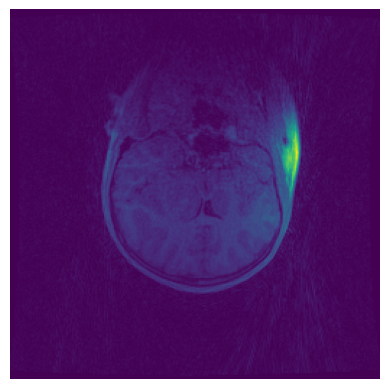

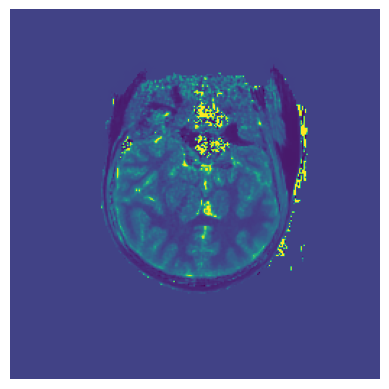

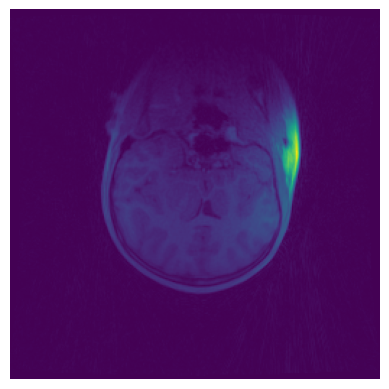

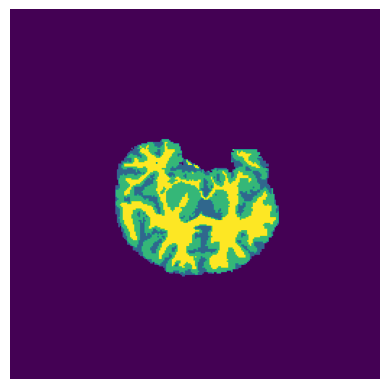

In [57]:
data = FullDataset(10)
x,gt,y,mask = data[610]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(gt[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(mask))
plt.show()

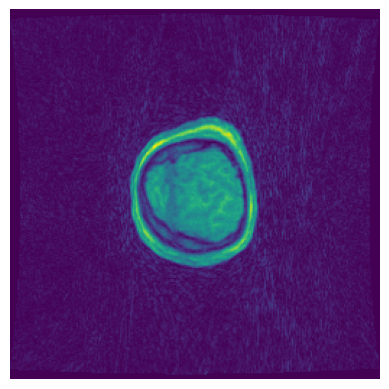

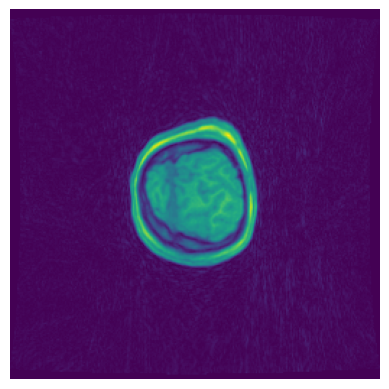

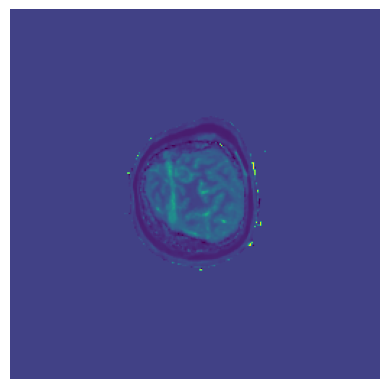

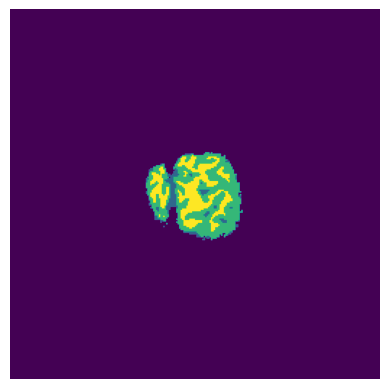

In [2]:
T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]

class T1_Denoise_Dataset(Dataset):
    
    def __init__(self, index, norm_factor=1000):
        self.name = samples[index]
 
    def __getitem__(self, index):
        return np.load(f'/scratch/mrphys/fullDataset/{self.name}/{index}.npy', allow_pickle=True)
        
    def __len__(self):
        return 768
    
data = T1_Denoise_Dataset(10)
x,gt,y,mask = data[700]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(gt[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(mask))
plt.show()

In [9]:
class T1_Denoise_Dataset(Dataset):
    def __init__(self, index, norm_factor=1000):
        self.name = samples[index]
    def __getitem__(self, index):
        x, y, gt, mask = np.load(f'/scratch/mrphys/fullDataset/{self.name}/{index}.npy', allow_pickle=True)
        return x, gt, y, mask
    def __len__(self):
        return 768

d = DataLoader(
    T1_Denoise_Dataset(10),
    batch_size=32,
    pin_memory=True,
    shuffle=False,
)

In [10]:
for x, gt, y, mask in d:
    break

In [11]:
x.shape

torch.Size([32, 10, 256, 256])

In [12]:
y.shape

torch.Size([32, 1, 256, 256])

In [13]:
gt.shape

torch.Size([32, 10, 256, 256])